https://slideslive.com/38941707/singlestation-earthquake-location-using-deep-neural-networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

import seisbench
import seisbench.data as sbd
import seisbench.generate as sbg

from tqdm.auto import tqdm

In [2]:
!pip install torch_harmonics

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from neuralop.models import *
from neuralop import Trainer
from neuralop import LpLoss, H1Loss
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

In [5]:
stead = sbd.STEAD(component_order='ZNE')

In [6]:
train, dev, test = stead.train_dev_test()
print(train)
print(dev)
print(test)

STEAD - 1075808 traces
STEAD - 63283 traces
STEAD - 126566 traces


In [7]:
surface_stations = np.load("surface_stations.npy")
surface_stations = np.array(list(set([i[:-4] for i in surface_stations])))

In [8]:
def read_snr(x):
    x = x[1:-1]
    return [float(i) for i in x.split(" ") if i != ""]

https://github.com/smousavi05/Deep-Bays-Loc/blob/main/ENZ_checker.py

In [9]:
MAX_DISTANCE = 1#110
def filter_data(data):
    data.filter(data.metadata["source_distance_km"].notnull())
    data.filter(data.metadata["source_magnitude"].notnull())
    data.filter(data.metadata["path_back_azimuth_deg"].notnull())
    data.filter(data.metadata["trace_sampling_rate_hz"] == 100)
    data.filter(data.metadata["source_distance_km"] <= MAX_DISTANCE)
    #data.filter(data.metadata["trace_p_arrival_sample"] >= 20)
    data.filter(data.metadata["source_magnitude"] > 0)
    #data.filter(data.metadata["source_magnitude"] < 4)
    data.metadata["trace_snr_db"] = data.metadata["trace_snr_db"].apply(lambda x: np.min(read_snr(x)))
    data.filter(data.metadata["trace_snr_db"] >= 25)
    data.metadata["surface_code"] = data.metadata["station_network_code"] + "_" + data.metadata["station_code"]
    data.filter(np.array([i in surface_stations for i in data.metadata["surface_code"]]))

filter_data(train)
filter_data(dev)
filter_data(test)

In [10]:
print(train)
print(dev)
print(test)

STEAD - 3528 traces
STEAD - 192 traces
STEAD - 416 traces


In [11]:
def prepare_control(dataset):
    control = []
    for i in range(len(dataset)):
        row = dataset.metadata.iloc[i]
        control_row = {"trace_name": row["trace_name"],
                       "start_sample": row["trace_p_arrival_sample"]-5,
                       "end_sample": row["trace_p_arrival_sample"]+25}
        control.append(control_row)
    return control

train_control = pd.DataFrame(prepare_control(train))
dev_control = pd.DataFrame(prepare_control(dev))
test_control = pd.DataFrame(prepare_control(test))

In [12]:
train_generator = sbg.SteeredGenerator(train, train_control)
dev_generator = sbg.SteeredGenerator(dev, dev_control)
test_generator = sbg.SteeredGenerator(test, test_control)

@test_generator.augmentation
@dev_generator.augmentation
@train_generator.augmentation
def add_augmentation(state_dict):
    state_dict["ps"] = (torch.tensor([state_dict['X'][1]["trace_s_arrival_sample"]-state_dict['X'][1]["trace_p_arrival_sample"]]), None)
    state_dict["y"] = (torch.tensor([state_dict['X'][1]["station_latitude_deg"]-state_dict['X'][1]["source_latitude_deg"],
                                    state_dict['X'][1]["station_longitude_deg"]-state_dict['X'][1]["source_longitude_deg"]]),
                       None)

train_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
dev_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
test_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

windowlen = 30
train_generator.augmentation(sbg.SteeredWindow(windowlen=windowlen))
dev_generator.augmentation(sbg.SteeredWindow(windowlen=windowlen))
test_generator.augmentation(sbg.SteeredWindow(windowlen=windowlen))

In [13]:
train_loader = DataLoader(train_generator, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_generator, batch_size=len(dev_generator), shuffle=False)
test_loader = DataLoader(test_generator, batch_size=1000, shuffle=False)

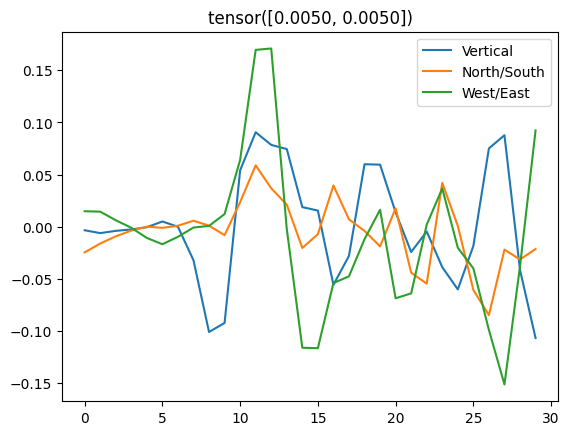

In [14]:
item = 0
plt.plot(train_generator[item]['X'].T)
plt.title(str(train_generator[item]['y']))
plt.legend(["Vertical", "North/South", "West/East"])
plt.show()

In [15]:
torch.set_default_dtype(torch.float32)

class FNORegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fno = FNO1d(n_modes_height=32,
                        hidden_channels=16,
                        in_channels=3,
                        out_channels=3,
                        n_layers=12)

        self.d = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.tanh = nn.Tanh()
        self.mlp1 = nn.Linear(3*30, 25)
        self.mlp2 = nn.Linear(25+1, 2)
        
    def forward(self, x, ps):
        x = self.d(self.tanh(self.fno(x)))
        return self.mlp2(torch.concatenate([self.d(self.tanh(self.mlp1(self.flatten(x)))), ps], axis=1))

class TCNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c0 = nn.Conv1d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.c1 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.c2 = nn.Conv1d(in_channels=12, out_channels=24, kernel_size=3, padding=1)

        self.d = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.tanh = nn.Tanh()
        self.mlp1 = nn.Linear(24*30, 25)
        self.mlp2 = nn.Linear(25+1, 2)
        
    def forward(self, x, ps):
        x = self.d(self.tanh(self.c0(x)))
        x = self.d(self.tanh(self.c1(x)))
        x = self.d(self.tanh(self.c2(x)))
        return self.mlp2(torch.concatenate([self.d(self.tanh(self.mlp1(self.flatten(x)))), ps], axis=1))

class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c0 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.c1 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.c2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1)

        self.d = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.tanh = nn.Tanh()
        self.mlp1 = nn.Linear(2160, 25)
        self.mlp2 = nn.Linear(25+1, 2)
        
    def forward(self, x, ps):
        x = x.unsqueeze(1)
        x = self.d(self.tanh(self.c0(x)))
        x = self.d(self.tanh(self.c1(x)))
        x = self.d(self.tanh(self.c2(x)))
        return self.mlp2(torch.concatenate([self.d(self.tanh(self.mlp1(self.flatten(x)))), ps], axis=1))

class MLPRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c0 = nn.Linear(30, 64)
        self.c1 = nn.Linear(64, 32)
        self.c2 = nn.Linear(32, 16)

        self.d = nn.Dropout(0.3)
        
        self.flatten = nn.Flatten()
        self.tanh = nn.Tanh()
        self.mlp1 = nn.Linear(16*3, 8)
        self.mlp2 = nn.Linear(8+1, 2)
        
    def forward(self, x, ps):
        x = x.unsqueeze(1)
        x = self.d(self.tanh(self.c0(x)))
        x = self.d(self.tanh(self.c1(x)))
        x = self.d(self.tanh(self.c2(x)))
        return self.mlp2(torch.concatenate([self.d(self.tanh(self.mlp1(self.flatten(x)))), ps], axis=1))


In [17]:
def deg_to_km(x):
    return torch.tan(x*(2*np.pi/360))*6371

In [21]:
device = 'cpu'

In [22]:
num_epochs = 2
min_losses = []
for model in [FNORegressor().to(device), TCNRegressor().to(device), CNNRegressor().to(device), MLPRegressor().to(device)]:
    criterion = nn.MSELoss()
    l1 = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    losses = []
    for epoch in tqdm(range(num_epochs)):
        epoch_losses = []
        for batch in (pbar:=tqdm(train_loader)):
            optimizer.zero_grad()
            outputs = model(batch['X'].to(device), batch['ps'].to(device, dtype=torch.float32))
            loss = criterion(outputs, batch['y'].to(device, dtype=torch.float32))
            epoch_losses.append(deg_to_km(l1(outputs, batch['y'].to(device, dtype=torch.float32))).item())
            loss.backward()
            optimizer.step()
            pbar.set_description(f'Epoch {epoch}/{num_epochs}: ' + f"Loss: %.5f km"%(np.mean(epoch_losses)))
        losses.append(np.mean(epoch_losses))
        scheduler.step()
    min_losses.append(min(losses))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
print(min_losses)

[133.26293670379363, 144.47558401296806, 60.08408895269171, 704.8031000360712]

In [ ]:
plt.plot(losses[1:])
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Validation MAE evolution")
plt.show()

In [ ]:
iter_test_loader = iter(test_loader)
data = next(iter_test_loader)
y, y_hat = data['y'], model(data['X'], data['ps']).detach().numpy()

In [ ]:
plt.hist(np.array(y_hat, copy=False), bins=100)
plt.show()

In [ ]:
plt.scatter(y[:, 0], y_hat[:, 0], marker='.')
plt.scatter(y[:, 1], y_hat[:, 1], marker='.')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend(["x", "y"])
plt.xlabel("Expected")
plt.ylabel("Predicted")
#plt.title(f"Average distance with ground truth: %.5f km"%np.mean((((y[:, 0]-y_hat[:, 0])**2) + ((y[:, 1]-y_hat[:, 1])**2))**0.5))
plt.show()

In [ ]:
for i in range(10):
    plt.plot([y[i, 0], y_hat[i, 0]], [y[i, 1], y_hat[i, 1]])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
#plt.title(f"Average distance with ground truth: %.5f km"%np.mean((((y[:, 0]-y_hat[:, 0])**2) + ((y[:, 1]-y_hat[:, 1])**2))**0.5))
plt.show()